Tutorial: Raster-scan simulations - photonic LDOS
===============================
*01/2021: updated to pyGDM v1.1+*

This is an example how to simulate photonic LDOS raster-scans in pyGDM.

We load the pyGDM modules:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pyGDM2 import structures
from pyGDM2 import materials
from pyGDM2 import fields
from pyGDM2 import propagators

from pyGDM2 import core
from pyGDM2 import linear
from pyGDM2 import nonlinear
from pyGDM2 import visu
from pyGDM2 import tools

Simulation setup
------------------

We will setup two simulations: One to calculate a decay-rate mapping (i.e. the LDOS) and a second for a "TPL"-type rasterscan. The latter can be used to get an approximation for the LDOS at the surface of the structure (see e.g. [1]).


[1] Viarbitskaya, S. et al. *Tailoring and imaging the plasmonic local density of states in crystalline nanoprisms.* Nat. Mater. **12**, 426–432 (2013)

structure initialization - automatic mesh detection: cube
structure initialization - consistency check: 420/420 dipoles valid


/home/hans/.local/lib/python3.8/site-packages/pyGDM2/visu.py:49: UserWarning: 3D data. Falling back to XY projection...
  warnings.warn("3D data. Falling back to XY projection...")


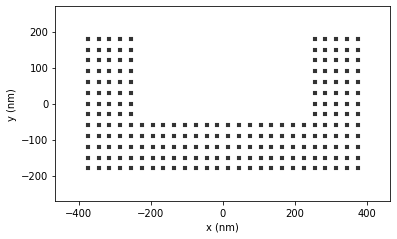

N dipoles: 420


In [2]:
## ---------- Setup structure
mesh = 'cube'
## -- note: in the paper example, a stepsize of 20nm was used. 
##          We increase the step for the sake of a shorter simulation runtime.
step = 30.0
geometry = structures.rect_split_ring(step, L1=800/step-1, L2=400/step-1, 
                                      W=180/step-1, H=int(60/step), mesh=mesh)

material = materials.dummy(2.0)

struct = structures.struct(step, geometry, material)
struct = structures.center_struct(struct)


## ---------- Setup incident field at each raster-scan position
## --- raster-scan height: at top-surface of structure
Z_scan = geometry.T[2].max()
r_probe = tools.generate_NF_map(-550,550,25, -310,310,15, Z_scan)

kwargs_focused = []
for x,y,z in r_probe:
    ## kwargs for focused illumination (TPL-method)
    kwargs_focused.append( dict(theta=0, spotsize=100, xSpot=x, ySpot=y) )
    kwargs_focused.append( dict(theta=90, spotsize=100, xSpot=x, ySpot=y) )

wavelengths = [600]
efield_focused = fields.efield(fields.focused_planewave, wavelengths=wavelengths, kwargs=kwargs_focused)


## ---------- environment
n1, n2 = 1.0, 1.0  # vacuum
dyads = propagators.DyadsQuasistatic123(n1=n1, n2=n2)


## ---------- Simulation initialization
sim_foc = core.simulation(struct, efield_focused, dyads)


## --- plot the structure
visu.structure(sim_foc.struct.geometry, scale=0.5)
print("N dipoles:", len(sim_foc.struct.geometry))

Let's run the simulations:
----------------------------

In [3]:
## scattering (--> SP-LDOS via TPL method)
sim_foc.scatter(verbose=True)

/home/hans/.local/lib/python3.8/site-packages/numba/core/dispatcher.py:237: UserWarning: Numba extension module 'numba_scipy' failed to load due to 'ValueError(No function '__pyx_fuse_0pdtr' found in __pyx_capi__ of 'scipy.special.cython_special')'.
  entrypoints.init_all()


timing for wl=600.00nm - setup: EE 12001.0ms, inv.: 326.7ms, repropa.: 3408.1ms (750 field configs), tot: 15736.0ms


1

Note that *core.scatter* and *core.decay_rate* calculated $(2 + 1) \times 25 \times 15 = 1125$ simulations.

Calcuate raster-scan maps
---------------------------
Now comes the part where we calculate the scalar raster-scan maps from the simulation results

In [4]:
## --- calculate TPL rasterscan maps
TPL0 = tools.calculate_rasterscan(sim_foc, 0, nonlinear.tpl_ldos, nonlin_order=1, verbose=True)
TPL90 = tools.calculate_rasterscan(sim_foc, 1, nonlinear.tpl_ldos, nonlin_order=1, verbose=True)


## --- decay rate simulation (--> LDOS)
## Note that the illumination is ignored by *core.decay_rate*
## field_index is used only to set the wavelength
ldos = core.decay_rate(sim_foc, field_index=0, r_probe=r_probe, verbose=True)

E-LDOS at wl=600.0nm - 

/home/hans/.local/lib/python3.8/site-packages/pyGDM2/tools.py:1395: UserWarning: 'field_kwargs' are index instead of dict.Using `get_possible_field_params_rasterscan`.Using configuration #0: '{'theta': 0, 'spotsize': 100, 'wavelength': 600}'
  warnings.warn("'field_kwargs' are index instead of dict." +
/home/hans/.local/lib/python3.8/site-packages/pyGDM2/tools.py:1395: UserWarning: 'field_kwargs' are index instead of dict.Using `get_possible_field_params_rasterscan`.Using configuration #1: '{'theta': 90, 'spotsize': 100, 'wavelength': 600}'
  warnings.warn("'field_kwargs' are index instead of dict." +


K: 0.6s, source-zone (108/375 pos): 0.0s, Q: 6.7s, S: 6.5s, integrate: 3.8s, Done in 17.6s


Plotting the maps
-------------------
Now we have calculated 2D scalar maps of the LDOS in a plane at the level of the top surface of the structure. Let's plot it together with the surface LDOS obtained by the "TPL-method":

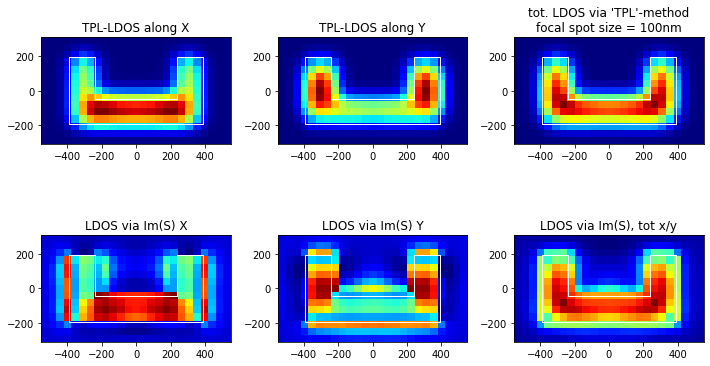

In [5]:
plt.figure(figsize=(10,6))

## --- plot "TPL-LDOS"
plt.subplot(231, aspect='equal'); plt.title("TPL-LDOS along X")
visu.scalarfield(TPL0, cmap='jet', show=False)
visu.structure_contour(sim_foc, color='w', input_mesh=mesh, show=False)


plt.subplot(232, aspect='equal'); plt.title("TPL-LDOS along Y")
visu.scalarfield(TPL90, cmap='jet', show=False)
visu.structure_contour(sim_foc, color='w', input_mesh=mesh, show=False)


TPL_tot = [TPL0[0], (TPL0[1]+TPL90[1])/2.]

plt.subplot(233)
plt.title("tot. LDOS via 'TPL'-method\nfocal spot size = {}nm".format(int(sim_foc.efield.kwargs[0]['spotsize'])))
visu.scalarfield(TPL_tot, cmap='jet', show=False)
visu.structure_contour(sim_foc, color='w', input_mesh=mesh, show=False)



## --- plot LDOS via field-susceptibility ("decay-rate method")
plt.subplot(234)
plt.title("LDOS via Im(S) X")
visu.scalarfield(ldos[0], cmap='jet', show=False)
visu.structure_contour(sim_foc, color='w', input_mesh=mesh, show=False)


plt.subplot(235)
plt.title("LDOS via Im(S) Y")
visu.scalarfield(ldos[1], cmap='jet', show=False)
visu.structure_contour(sim_foc, color='w', input_mesh=mesh, show=False)

ldos_avg_xy = ldos[0].copy()
ldos_avg_xy.T[3] += ldos[1].T[3]
ldos_avg_xy.T[3] /= 2.0

plt.subplot(236)
plt.title("LDOS via Im(S), tot x/y")
visu.scalarfield(ldos_avg_xy, cmap='jet', show=False)
visu.structure_contour(sim_foc, color='w', input_mesh=mesh, show=False)


plt.tight_layout()
plt.show()

The agreement is qualitatively ok, the global trends are similar. The TPL-method gives however only an approximation to the LDOS at the surface. Also only the LDOS at the actual surface of the structure can be obtained using the TPL method with an unphysically tight beam. The LDOS *outside* the structure must in any case be calculated using the technique via the imaginary part of the field susceptibility (--> via the decay rate).